In [37]:
import os
import pandas as pd

df_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/processed_data/{filename}")
    df_list.append(df)

In [38]:
def extract_features(df):
    res = df["resistance"]
    return [
        res.mean(),
        res.std(),
        res.min(),
        res.max(),
        res.skew(),
        res.kurtosis(),
        (res > 0).mean(),
        res.diff().abs().mean(),  # smoothness
    ]

In [39]:
# def get_representation(df, )

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for df in df_list:
    representation_list.append(extract_features(df))
print(f"example: {representation_list[0]}")

example: [np.float64(0.1021797467496816), 0.09371445944851854, 0.0011380695364706, 0.3395864884960055, np.float64(1.2032118536762233), np.float64(0.4324815130391251), np.float64(1.0), np.float64(0.0036866373059574477)]


## K-Means Clustering Implementation w/ k-means++ init for centroids

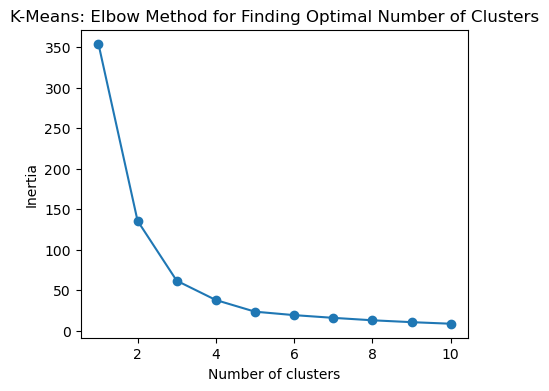

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1000).fit(representation_list)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(5,4))
plt.plot(range(1,11), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# print(kmeans.labels_)
# print(kmeans.score(representation_list))

# kmeans.predict # for predicting which cluster a data point belongs too

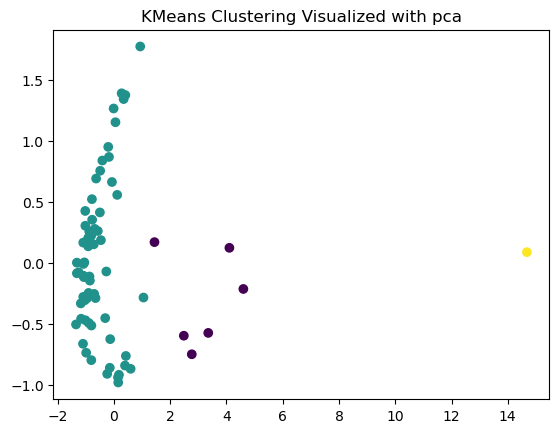

y_label: 0


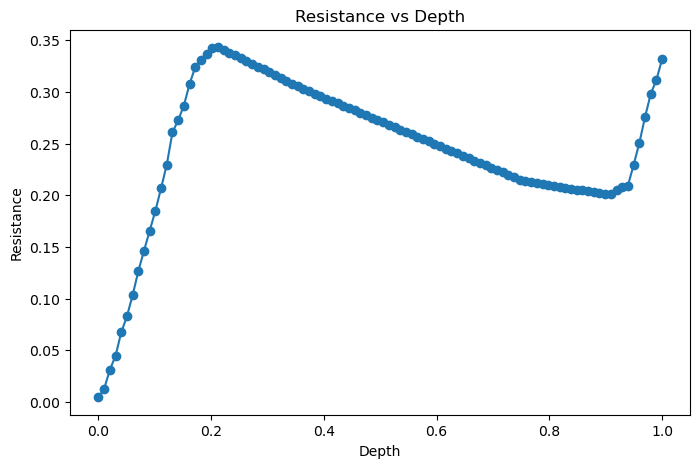

y_label: 0


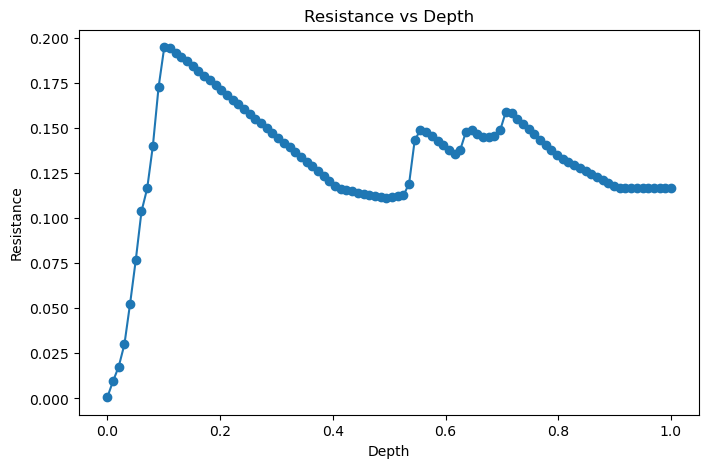

y_label: 0


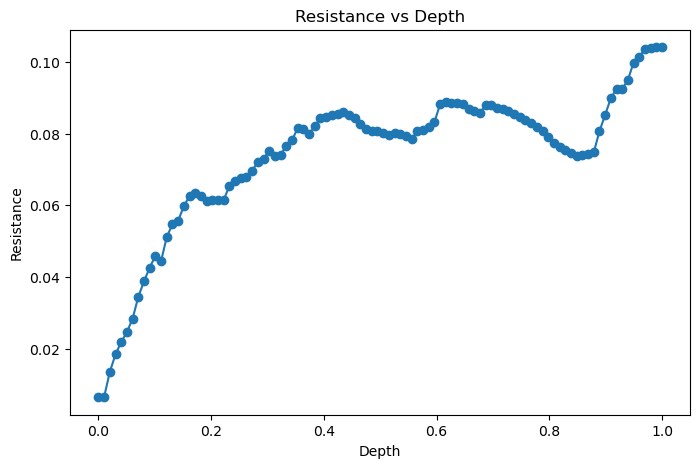

y_label: 0


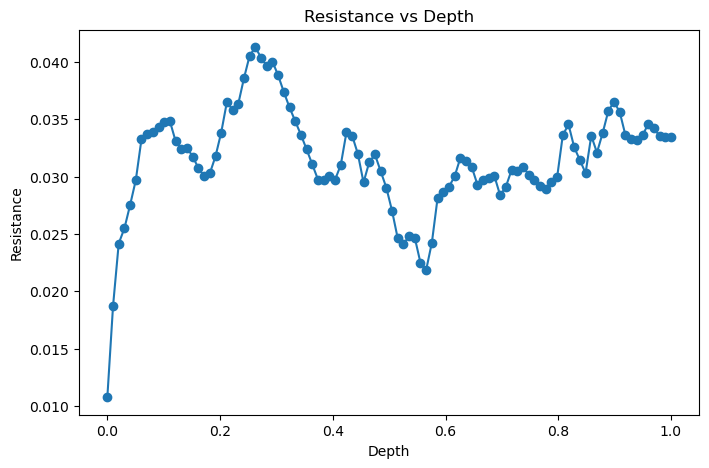

y_label: 0


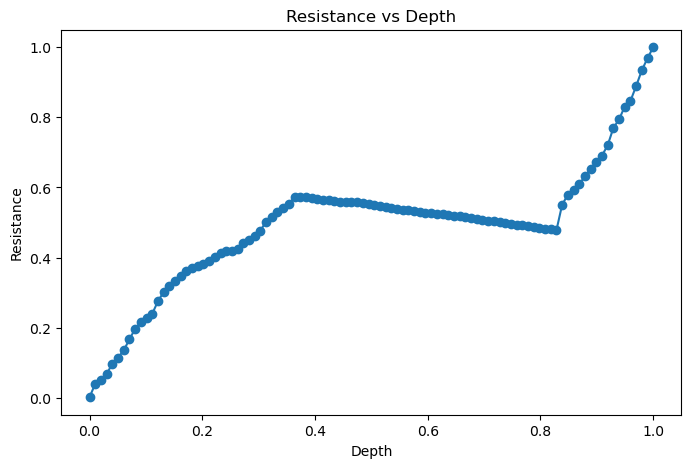

y_label: 1


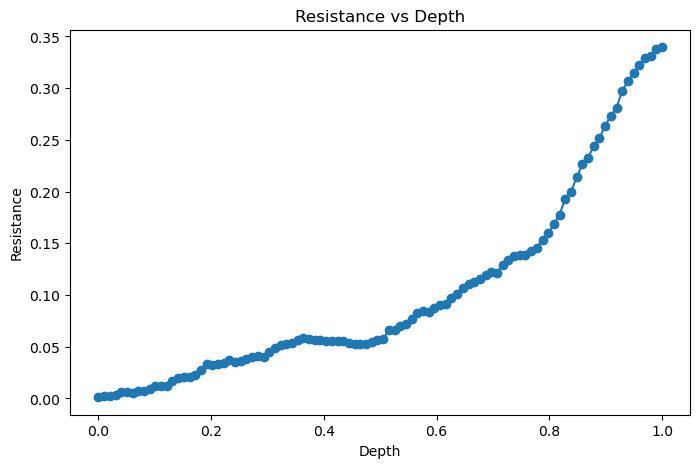

y_label: 1


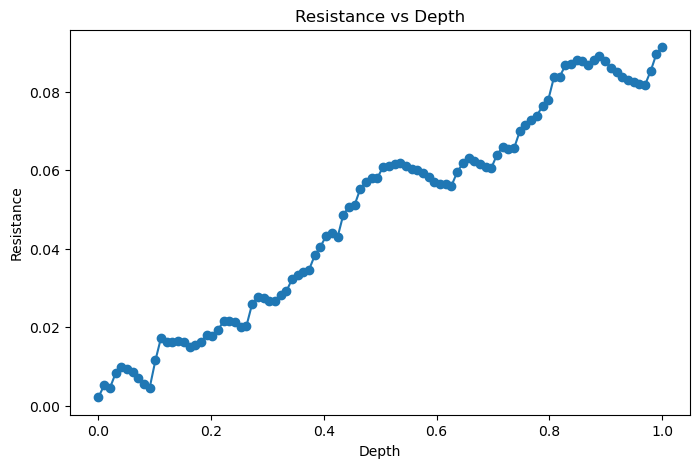

y_label: 1


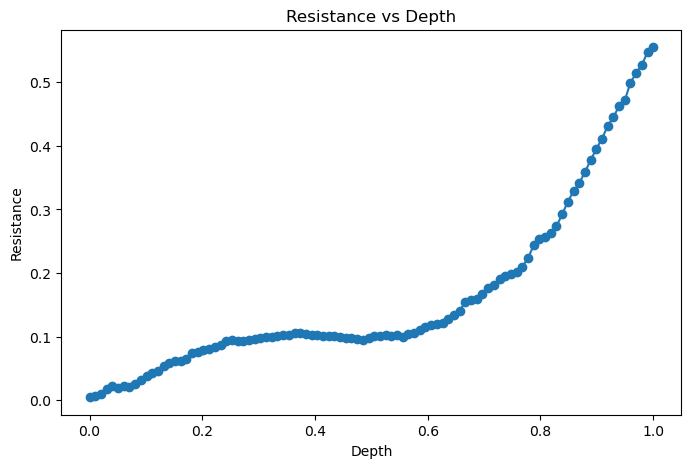

y_label: 1


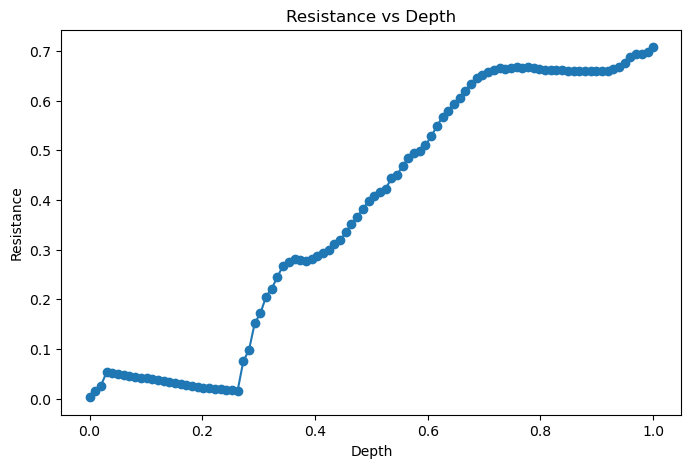

y_label: 1


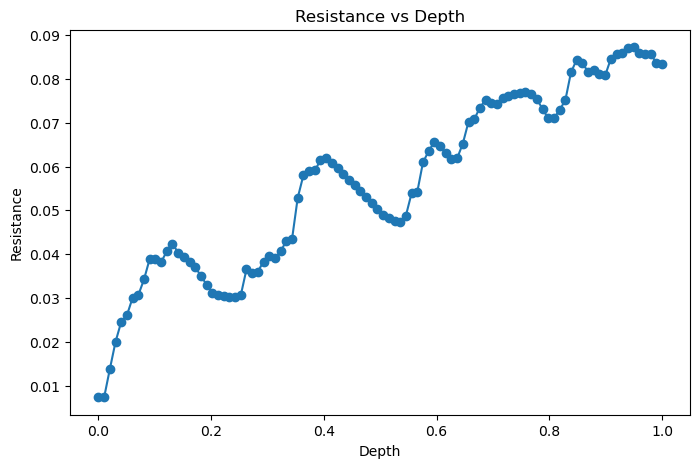

y_label: 2


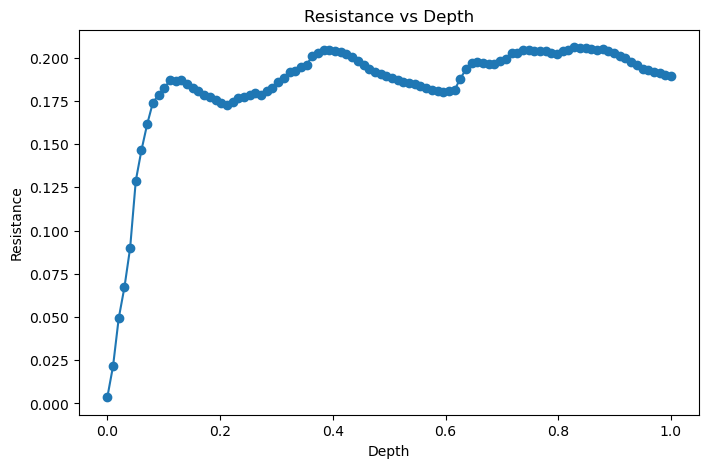

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_clusters(representation_list, y_labels, use_pca=False, use_sne=False):
    """
    A linear method that projects your data into a new 2D coordinate system that captures maximum variance.
    It compresses the data while retaining its most important patterns.
    Fast and good for general structure.
    """
    if use_pca:
        pca = PCA(n_components=2) # reduce data down to 2 dims
        X_pca = pca.fit_transform(representation_list) # learns directions of max vairance, projects onto 2D
        # print(y_labels)
        plt.title("KMeans Clustering Visualized with pca")
        # x_pca: x_dim, x_pca: y_dim, c: color points based on clusters, cmap: color map
        plt.scatter(X_pca[:,0], X_pca[:,1], c=y_labels, cmap='viridis')
        plt.show()
    """
    A nonlinear technique focused on preserving local neighborhoods.
    Often shows tight, separated clusters, even when PCA shows overlapping blobs.
    """
    if use_sne:
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(np.array(representation_list))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_labels, cmap='coolwarm')
        plt.title("KMeans Clustering Visualized with t-SNE")
        plt.xlabel("t-SNE Feature 1")
        plt.ylabel("t-SNE Feature 2")
        plt.show()

def display_curve(df_list, graph_i):
    plt.figure(figsize=(8,5))       
    plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
    plt.xlabel('Depth')
    plt.ylabel('Resistance')
    plt.title('Resistance vs Depth')
    plt.show()

# display max 2 graphs per label
def visualize_cluster_curves(df_list, y_labels, max_num_graphs_per_cluster=2):
    # Index list
    df_list_i = list(range(len(df_list)))

    # Sort y_labels and indices together
    y_labels_sorted, df_list_sorted = zip(*sorted(zip(y_labels, df_list_i)))
    y_labels_sorted = list(y_labels_sorted)
    df_list_sorted = list(df_list_sorted)

    displayed_count = {}  # Track how many times we've displayed each label

    for i in range(len(y_labels_sorted)):
        label = y_labels_sorted[i]
        index = df_list_sorted[i]

        # Display at most 2 curves per label
        if displayed_count.get(label, 0) < max_num_graphs_per_cluster:
            print(f"y_label: {label}")
            display_curve(df_list, index)
            displayed_count[label] = displayed_count.get(label, 0) + 1

kmeans = KMeans(n_clusters=3, init="k-means++", n_init=1000).fit(representation_list)
visualize_clusters(representation_list, kmeans.labels_, use_pca=True, use_sne=False)
visualize_cluster_curves(df_list, kmeans.labels_, max_num_graphs_per_cluster=5)

# Hierarchical Clustering

[45 66 51 46 37 35 57 47 69 65 61 38 48 60 50 53 34 64 59 29 63 43 49 67
 55 41 22 52 54 40 31 68 26 58 44 23 39 42 32 62 30 56 18 21 14 28 36 33
 25 27 15 13 19 17  8 16 10 24  7  6  3 20 12 11  9  5  2  4  1  0]


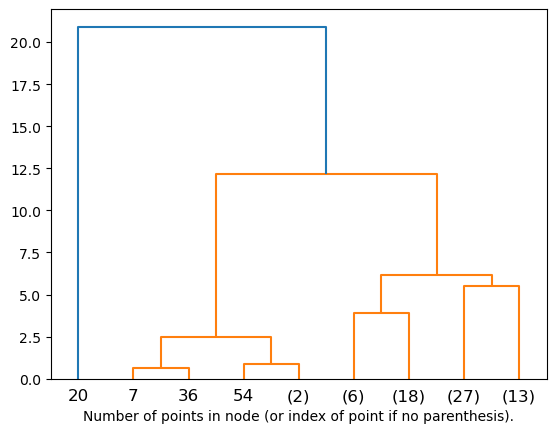

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical = hierarchical.fit(representation_list)
print(hierarchical.labels_)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
# no more than p levels o fthe dendrogram tree are displayed
plot_dendrogram(hierarchical, truncate_mode="level", p=3)
# plot_dendrogram(hierarchical, p=3)

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()